##SEQUENCE GENERATOR CLASS

In [14]:
import numpy as np
import pandas as pd

class SequenceGenerator:
    """
    Generates sliding window sequences for LSTM input from the processed DataFrame.
    """
    def __init__(self, df, sequence_length=50, step=5):
        self.df = df.copy()
        self.sequence_length = sequence_length
        self.step = step
    def generate_sequences(self):
        """
        Returns:
            X: np.ndarray of shape (num_sequences, sequence_length, num_features)
            y: np.ndarray of shape (num_sequences,)
        """
        X, y = [], []
        feature_cols = [
    'TimeDelta',
    'SensorID_enc',
    'event_count',
    'progress_ratio',
    'TimeOfDay_enc',
    'SensorType_enc',
    'sensor_value_binary',
    'sensor_value_continuous'
]
        # Group by participant and task to avoid mixing data
        for (pid, tid), group in self.df.groupby(['participant_id', 'task_id']):
            group = group.reset_index(drop=True)
            label = group.loc[0, 'task_id']  # All rows in this group have the same label
            for start in range(0, len(group) - self.sequence_length + 1, self.step):
                end = start + self.sequence_length
                window = group.loc[start:end-1, feature_cols].values
                if window.shape[0] == self.sequence_length:
                    X.append(window)
                    y.append(label)
        X = np.array(X)
        y = np.array(y)
        return X, y



##MODEL TRAINING


--- Fold 1 ---
Fold 1 Accuracy: 0.976

--- Fold 2 ---
Fold 2 Accuracy: 0.951

--- Fold 3 ---
Fold 3 Accuracy: 0.975

=== Final Evaluation ===
Average Test Accuracy: 0.967

Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        25
           2       0.98      0.97      0.98       226
           3       1.00      0.75      0.86         8
           4       0.95      0.96      0.95       108

    accuracy                           0.97       367
   macro avg       0.96      0.92      0.94       367
weighted avg       0.97      0.97      0.97       367



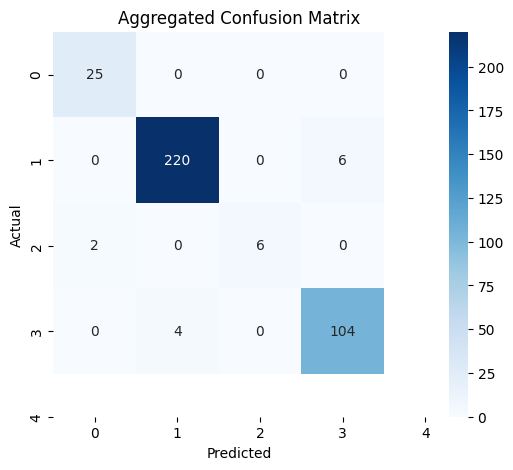

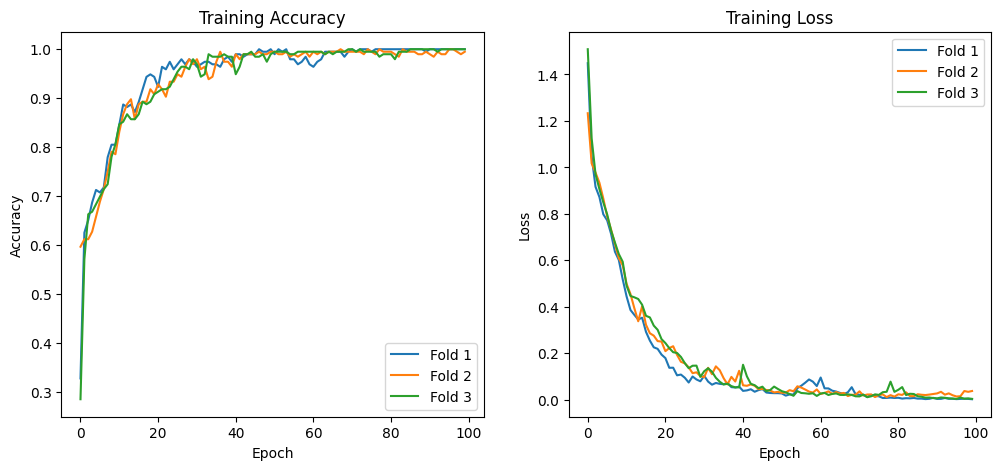

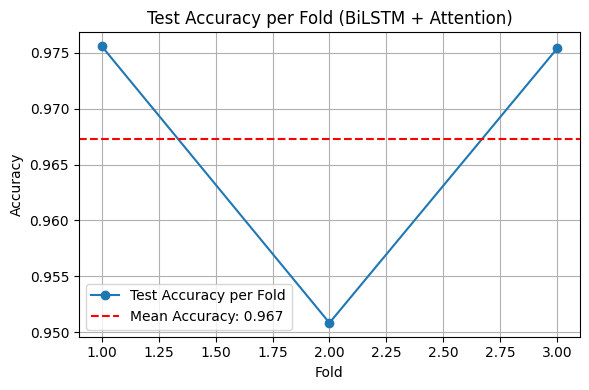

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score  
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout, Layer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf


def plot_conf_matrix(cm, class_names, title):
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


# ------------------------------
# Attention Layer Definition
# ------------------------------
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], 1),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[1], 1),
                                 initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)

# ------------------------------
# BiLSTM + Attention Model
# ------------------------------
def build_bilstm_attention(input_shape, num_classes):
    inp = Input(shape=input_shape)
    x = Bidirectional(LSTM(64, return_sequences=True))(inp)
    x = Dropout(0.3)(x)
    x = Attention()(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inp, outputs=out)
    return model

# ------------------------------
# Main Training Script
# ------------------------------


def main():
    PROCESSED_CSV = 'combined_dataset_II.csv'
    SEQUENCE_LENGTH = 50
    STEP = 5

    df = pd.read_csv(PROCESSED_CSV)
    seq_gen = SequenceGenerator(df, sequence_length=SEQUENCE_LENGTH, step=STEP)
    X, y = seq_gen.generate_sequences()

    num_classes = 5
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    all_y_true = []
    all_y_pred = []
    acc_list = []
    histories = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
        print(f"\n--- Fold {fold} ---")

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        y_train_cat = to_categorical(y_train, num_classes)
        y_test_cat = to_categorical(y_test, num_classes)

        model = build_bilstm_attention((SEQUENCE_LENGTH, X.shape[2]), num_classes)
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        history = model.fit(
            X_train, y_train_cat,
            validation_split=0.2,
            epochs=100,
            batch_size=32,
            verbose=0,
            #callbacks=[early_stop]
        )

        histories.append(history)

        y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
        acc = accuracy_score(y_test, y_pred)
        acc_list.append(acc)

        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)

        print(f"Fold {fold} Accuracy: {acc:.3f}")

    # ------------------------------
    # Final Results
    # ------------------------------
    print("\n=== Final Evaluation ===")
    avg_acc = np.mean(acc_list)
    print(f"Average Test Accuracy: {avg_acc:.3f}")

    print("\nClassification Report:")
    print(classification_report(all_y_true, all_y_pred))

    cm = confusion_matrix(all_y_true, all_y_pred)
    plot_conf_matrix(cm, class_names=[str(i) for i in range(num_classes)], title="Aggregated Confusion Matrix")

    # ------------------------------
    # Plot Training Curves
    # ------------------------------
    plt.figure(figsize=(12,5))

    for i, hist in enumerate(histories, 1):
        plt.subplot(1,2,1)
        plt.plot(hist.history['accuracy'], label=f'Fold {i}')
        plt.title('Training Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')

        plt.subplot(1,2,2)
        plt.plot(hist.history['loss'], label=f'Fold {i}')
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')

    plt.subplot(1,2,1)
    plt.legend()
    plt.subplot(1,2,2)
    plt.legend()
    plt.show()


    # ------------------------------
    # Plot Test Accuracy per Fold
    # ------------------------------
    plt.figure(figsize=(6,4))
    plt.plot(range(1, len(acc_list)+1), acc_list, marker='o', label='Test Accuracy per Fold')
    plt.axhline(avg_acc, color='red', linestyle='--', label=f"Mean Accuracy: {avg_acc:.3f}")
    plt.title('Test Accuracy per Fold (BiLSTM + Attention)')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

if __name__ == '__main__':
    main()

